# Contenido (hipervínculos)

1. <a href="L2D"> Modelo </a>

2. <a href="#caso1">Caso 1: Cilindro sumergido</a>

3. <a href="#caso2"> Caso 2: Isla cónica (NOAA)</a>

4. <a href="#caso3"> Caso 3: Chile 2010 (Moreno)</a>

<a id="L2D"> </a>
 # COMCOT  lineal 2D sin borde móvil


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Caso 3: Tsunami Chile 2010

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat


    361 ncols
    361 nrows
    -120.0 xll
    -60.0 yll
    0.166666666667 cellsize
    999999 nodata_value

In [28]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
topo_fname = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname,
        verbose=True)

data = np.loadtxt('etopo10min120W60W60S0S.asc',skiprows=6)
topo = np.reshape(data,(361,361))
lon = np.arange(-120.,-120+361*0.1666666667,0.1666666667)
lat = np.arange(-60.,-60+361*0.1666666667,0.1666666667)


Skipping http://www.geoclaw.org/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: ./etopo10min120W60W60S0S.asc


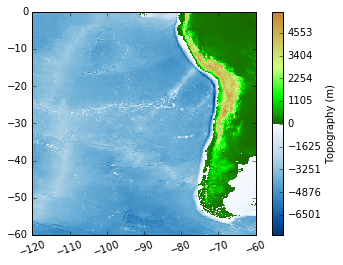

In [8]:
topo2 = topotools.Topography(topo_fname, topo_type=2)
topo2.plot()

In [35]:
import utm
xy = [utm.from_latlon(lat[i],lon[i],force_zone_number=16)[:2] for i in range(lat.shape[0])]
xy = np.array(xy)

In [36]:
utm.from_latlon(np.mean(lat),np.mean(lon))

(210590.3472817397, 6677424.096298146, 16, 'J')

(-2000000.0, 4000000.0, 2000000.0, 10000000.0)

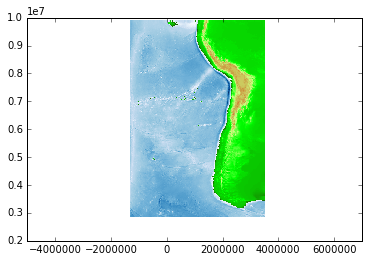

In [37]:
x2,y2 = np.meshgrid(xy[:-5,0],xy[:-5,1])
plt.pcolormesh(x2,y2,np.flipud(topo[:-5,:-5]),cmap=cmap)
plt.axis('equal')

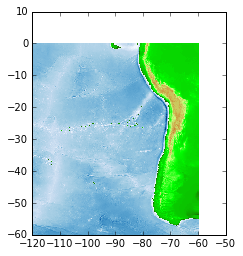

In [38]:
import clawpack.visclaw.colormaps as colormaps
import matplotlib.colors as colors



land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
topo_extent = [topo2.Z.min(),topo2.Z.max()]
mean_lat = 0.5*(topo2.extent[2]+topo2.extent[3])
if topo_extent[0] > 0.0:
    cmap = land_cmap
    norm = colors.Normalize(vmin=0.0, vmax=topo_extent[1])
elif topo_extent[1] <= 0.0:
    cmap = sea_cmap
    norm = colors.Normalize(vmin=topo_extent[0], vmax=0.0)
else:
    cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                         data_limits=topo_extent,
                                         data_break=0.0)
f = plt.figure()
ax = f.add_subplot(111)
ax.pcolormesh(lon,lat,np.flipud(topo),cmap=cmap)
# ax.pcolormesh(topo2.X,topo2.Y,topo2.Z,cmap=cmap)
ax.ticklabel_format(style="plain",useOffset=False)
ax.set_aspect(1/np.cos(np.pi*mean_lat/180))    

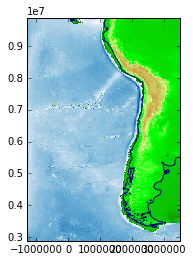

In [42]:
plt.pcolormesh(x2,y2,np.flipud(topo[:-5,:-5]),cmap=cmap)
plt.contour(x2,y2,np.flipud(topo[:-5,:-5]),[0.0])
plt.gca().set_aspect(1)
# plt.gca().set_aspect(1/np.cos(np.pi*mean_lat/180))

In [ ]:
h = loadmat('../data/MorenoCS_h')
falla = loadmat('../data/MorenoCS_z')

In [ ]:
xb = h['xh'][0,0][0,:]
yb = h['yh'][0,0][0,:]
zb = h['zh'][0,0]
zf = falla['zf'][0,0]
xf = falla['xf'][0,0][0,:]
yf = falla['yf'][0,0][0,:]

In [ ]:
# plt.figure(figsize=(9,9))
r = 6
print xb[::r].shape,yb[::r].shape,zb[::r,::r].shape
plt.subplot(121)
plt.pcolormesh(xb[::r],yb[::r],zb[::r,::r],vmin=-8000,vmax=6000)
plt.axis('equal')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(xf[::r],yf[::r],zf[::r,::r],vmin=0.0)
plt.axis('off')
plt.axis('equal')
plt.tight_layout()

In [ ]:
r = 3
nt = 60
x = xb[::r] - xb.min()
y = yb[::r] - yb.min()
x,y = np.meshgrid(x,y,indexing='ij')
h = -zb[::r,::r].T

nx,ny = x.shape
plt.pcolormesh(x,y,-h)
plt.axis('equal')
plt.colorbar()
print nx,ny

In [ ]:
p = np.zeros((nt,nx,ny))
q = np.zeros((nt,nx,ny))
cfl = 0.45
dx = np.diff(x.T)[0,0]
dy = np.diff(y)[0,0]
dt = cfl*min(dx,dy)/np.sqrt(np.max(h)*9.81)
rx = dt/dx
ry = dt/dy
gx = 1e-2
grx = 9.81*dt/dx
gry = 9.81*dt/dy
print dx,dy,dt,rx,ry,gx

In [ ]:
eta = np.zeros((nt,nx,ny))
eta[0,:,:] = zf[::r,::r].T
eta[0,:,:] = np.where(eta[0,:,:]<0,0.0,eta[0,:,:])
eta[0,:,:] = np.where(h>gx,eta[0,:,:],-h)

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.pcolormesh(x,y,zf[::r,::r].T,vmin=0.0)
plt.colorbar()
plt.axis('equal')
plt.subplot(132)
plt.pcolormesh(x,y,eta[0,:,:],vmax=4)
plt.axis('equal')
plt.title(u'$\eta$',fontsize=26)
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(x,y,eta[0,:,:])
plt.axis('equal')
plt.title(u'$\eta$',fontsize=26)
plt.colorbar()
plt.tight_layout()

In [ ]:
eta,p,q = simulation(x,h,eta,p,q,rx,ry,dx,dy,cfl,nt,gx)
print 'finished!'

In [ ]:
plt.pcolormesh(x,y,eta[1,:,:],vmax=4.)

In [ ]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
quad1 = ax2.pcolormesh(x,y,eta[0,:,:],vmax=5.,vmin=-5.,
                       shading='gouraud',cmap=plt.cm.seismic)
plt.pcolormesh(x,y,np.ma.masked_where(h>0,-h),vmin=0.0,vmax=8000, cmap=plt.cm.Greens_r)
ax2.contour(x,y,h,[0.,10.,100.,1000.],colors='k')
ax2.contour(x,y,h,[-10.,-100.,-1000.],colors='w')
ax2.set_axis_off()
t = ax2.set_title('Time = %.2f min'%(0.0))
# ax2.set_xlim(-10,5)
# ax2.set_ylim(-5,5)
cb2 = fig.colorbar(quad1,ax=ax2)
ax2.set_aspect('equal')
def init():
    quad1.set_array([])
    return quad1,


def animate(i):
    t.set_text('Time = %.2f min'%(i*dt/60.))
    quad1.set_array(np.ma.masked_where(h<0,eta[i*1,:,:]).ravel())
    return quad1,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=60, interval=100)

Funciona!, hay que revisar el borde superior (refleja), pero ya es aceptable para empezar en la GPU.

In [1]:
x.min()

NameError: name 'x' is not defined

# El futuro

* Sponge layer o alguna condición de borde que sí funcione
* Okada model: LISTO
* GPU: LISTO
    * Batimetría como imagen png: LISTO
* Coordenadas esféricas